## Figure of merit

**The notebook presents a function which take as input the bundleDicts from the metric and it builds a bar plot with the rank of all the opsims. The rank is estimated summing the metric value all over the footprint.**

In [135]:
%matplotlib inline
import sys,os, glob
import numpy as np
import math
from opsimUtils import *
import matplotlib.pyplot as plt
import pandas as pd
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.db as db
import lsst.sims.maf.plots as plots
from lsst.sims.maf.metrics import BaseMetric
from lsst.sims.maf.utils import m52snr, sigma_slope, astrom_precision
from builtins import zip

In [136]:
plt.style.use('seaborn')
plt.rc('legend', fontsize=20)

- your_username has to be set to be able to access to the proper directory.

- outDir has to be set to be able to access to the MAFOutput file.

In [137]:
your_username = 'fragosta'
if your_username == '': # do NOT put your username here, put it in the cell at the top of the notebook.
    raise Exception('Please provide your username!  See the top of the notebook.')
    
outDir = '/home/idies/workspace/Storage/{}/persistent/MAFOutput/MetricData/PM'.format(your_username)

resultDbs = getResultsDbs(outDir)

# the following line will be useful if you did not run MAF on all 75 opsims
#Here we upload the results from the MAFoutput of interest
runNames = list(resultDbs.keys())
bundleDicts = {}
for runName in runNames:
       bundleDicts[runName] = bundleDictFromDisk(resultDbs[runName], runName, outDir)


Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Healpix slic

nomalization factors and/or tresholds for the FOM and MAF values can be set in the function to plot the selection we want to show.

- norm can be a string ('std'),in this case it apply as normalization the standard deviation of the MAF distribution over the footprint; norm can be None, in this case no normalization is applyed; norm can be a dictionary with the normalization value for all the opsim for the number of metrics we want to plot.

- threshold_max is the upper limit for the threshold, can be a number or a dictionary if the threshold has to be different for the different metrics.

- treshold_max is the lower limit for the threshold,can be a number or a dictionary if the threshold has to be different for the different metrics.

- byfamily is a boolean variable, if True the Opsims are sorted by theri families.

In [143]:
def get_family(df):
    """get family of opsim"""    
    return df[0].split('_')[0]

def FOM(bundleDicts, norm=None, treshold_min =None, treshold_max =None, filename=None, byfamily=True,**karg):
    data_bundle = {}
    data = {}
    FOMs = []
    runNames= list(bundleDicts.keys())
    metrics = bundleDicts[runNames[0]].keys()
    for metric in metrics:
        data_bundle[metric]={}
        data[metric]={}
        FOM=[]
        for runName in runNames: 
            data_bundle[metric][runName]= pd.DataFrame(bundleDicts[runName][metric].metricValues[np.where(bundleDicts[runName][metric].metricValues.mask == False)])[0]
            data[metric][runName]= [] 
            for i in range(len(data_bundle[metric][runName])):        
                if data_bundle[metric][runName][i]:
                    data[metric][runName].append(data_bundle[metric][runName][i])
            data[metric][runName]=np.array(data[metric][runName])[np.where(np.isfinite(data[metric][runName]))]
            if treshold_min !=None and treshold_max !=None :
                if isinstance(treshold_min,dict) and isinstance(treshold_max,dict):
                    ID_fom=np.where((data[metric][runName]>treshold_min[metric][runName]) & (data[metric][runName]<treshold_max[metric][runName]))
                else:
                    ID_fom=np.where((data[metric][runName]>treshold_min) & (data[metric][runName]<treshold_max))
            else:
                if treshold_min !=None:
                    if isinstance(treshold_min,dict):
                        ID_fom=np.where(data[metric][runName]>treshold_min[metric][runName])
                    else:
                        ID_fom=np.where(data[metric][runName]>treshold_min)
                elif treshold_max !=None :
                    if isinstance(treshold_min,dict):
                        ID_fom=np.where(data[metric][runName]>treshold_max[metric][runName])
                    else:
                        ID_fom=np.where(data[metric][runName]>treshold_max)
                else:
                    ID_fom=np.repeat(True, len(data[metric][runName]))
            if norm =='std':
                N= np.std(np.array(data[metric][runName][ID_fom]))**(-1)
            elif norm==None:
                N=np.repeat(1,len(data[metric][runName][ID_fom]))
            else:
                N=norm[metric][runName][ID_fom]
            fom = np.array(data[metric][runName][ID_fom])*N
            FOM.append(fom.sum())
        FOM=np.array(FOM)
        FOMs.append(FOM) 
    
    import matplotlib.cm as cm
    plt.rcdefaults()
    fig, ax = plt.subplots(figsize=(8,30))
    y_pos = np.arange(len(bundleDicts.keys()))
    colorlist = cm.rainbow(np.linspace(0, 1, len(FOMs)))
    d= np.zeros(len(runNames))
    dplt=[]
    FOM_labels= list(bundleDicts[runNames[0]].keys())
    df_new = pd.DataFrame(bundleDicts.keys(), columns=['db'])
    for i, (FOM, maf) in enumerate(zip(FOMs,FOM_labels)):
        d = d+ FOM
        #dplt.append(d)
        df_new[maf]= d
    df_new['db'] = df_new['db'].apply(lambda x: x.replace("_v1.4_10yrs", "") )
    df_new['db'] = df_new['db'].apply(lambda x: x.replace("v1.4_10yrs", "") )
    df_new['family'] = df_new.apply(get_family, axis=1)
    if byfamily:
        df_ = df_new.sort_values(by=[ 'family',FOM_labels[-1]], ascending=[False, False])
    else:
        df_ = df_new.sort_values(by=[FOM_labels[-1]], ascending=[False])
    #idx = sorted([name_tick,d], key = lambda x: (x[1],x[2]))
    #idx=np.argsort((d,name_tick))
    #idx=idx[::-1]
    
    for i in reversed(range(len(FOMs))):
        #ax.barh(y_pos,dplt[i][idx], align='center',color=colorlist[i],label=FOM_labels[i], **karg)
        ax.barh(df_['db'],df_[FOM_labels[i]], align='center',color=colorlist[i],label=FOM_labels[i], **karg)
    if byfamily:
        hlines = df_.groupby(by='family', as_index=False, sort=False).count().cumsum()[FOM_labels[-1]].values - 0.5
        hlines = [hlines, hlines]
    xmin, xmax= ax.get_xlim()
    ax.plot((xmin, xmax), hlines, 'k-', linewidth=1, alpha=0.5)
    ax.set_yticks(y_pos)
    #ax.set_yticklabels(name_tick, size=20)
    ax.set_yticklabels(df_['db'], size=20)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlim(xmin, xmax)
    ax.set_xlabel('FoM', size=20)
    ax.legend(loc='upper right',fontsize=12)
    if filename!=None:
        plt.savefig(filename+'.png')
    plt.close()
    return fig

/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


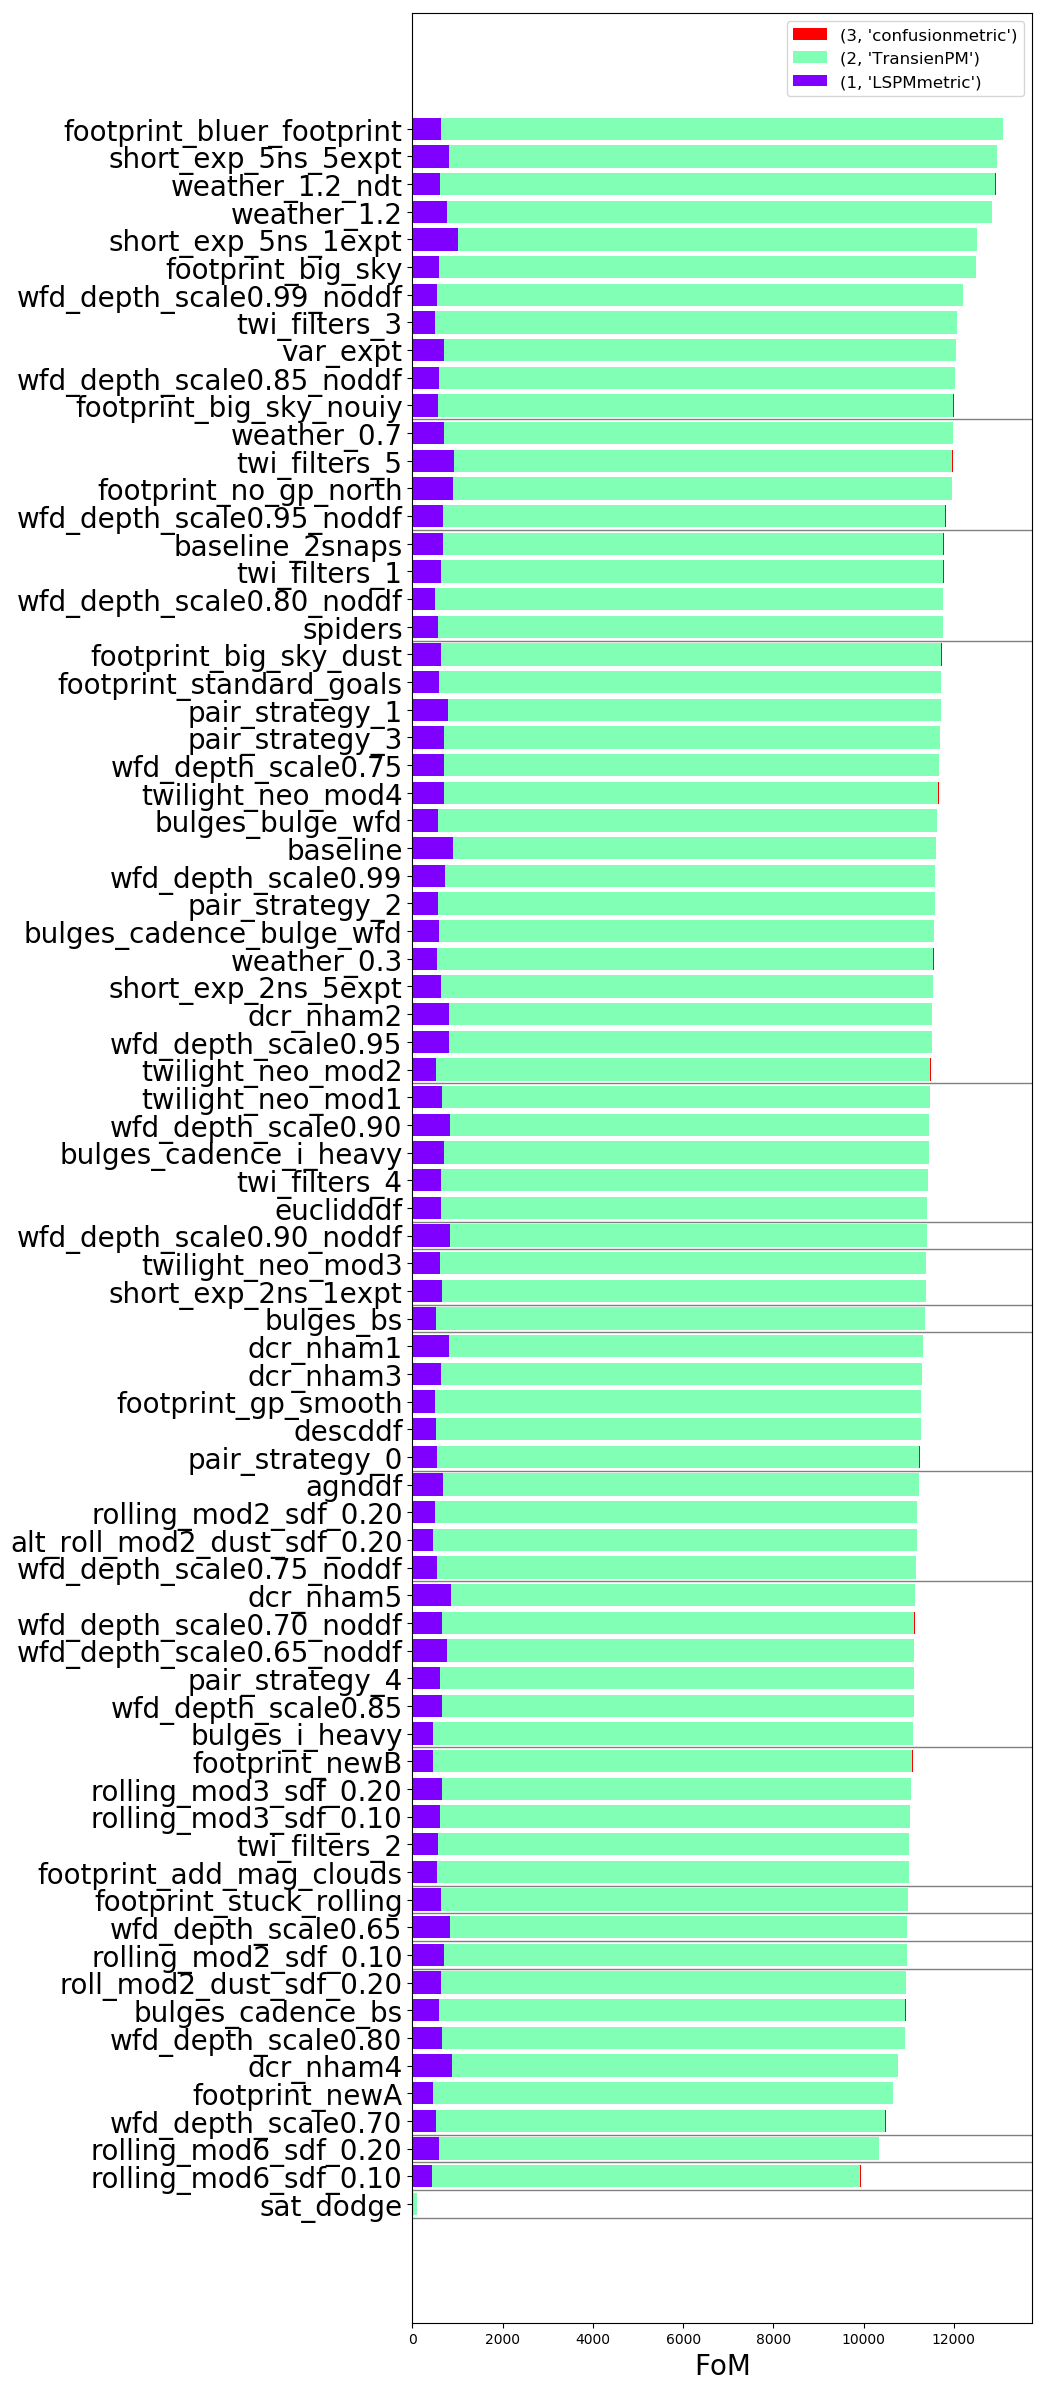

In [142]:
FOM(bundleDicts, norm='std', byfamily=False)